In [1]:
import os
import math

import matplotlib
import numpy as np
import sys
import scipy
import yaml

from sklearn.metrics import mean_squared_error

sys.path.append('../')
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from matplotlib import cm

from slow_reservoir.model import RNN
from slow_reservoir.dataset.dynamic_state import State

%matplotlib inline

In [2]:
sigma_sq = 0.5

In [3]:
def make_signal_for_prior(time_length, mu_p, sigma_p, uncertainty=0.5, g=1.25):
    input_signals = np.zeros([1, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    
    state = State(mu=mu_p, sigma=sigma_p)
    
    for i in range(1):
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = state()
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
        
        input_signals[i] = signal_input
        
    return input_signals

In [4]:
config_path = '../slow_reservoir/trained_model/dynamic_state_random/20220526_1_stable/20220526_1_stable.cfg'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
    

model_name = os.path.splitext(os.path.basename(config_path))[0]
print('model_name: ', model_name)

torch.manual_seed(1)
device = torch.device('cpu')

model = RNN(
    n_in=cfg['DATALOADER']['INPUT_NEURON'],
    n_out=1,
    n_hid=cfg['MODEL']['SIZE'],
    n_reservoir=cfg['MODEL']['RESERVOIR'],
    device=device,
    alpha_fast=cfg['MODEL']['ALPHA_FAST'],
    alpha_slow=cfg['MODEL']['ALPHA_SLOW'],
    sigma_neu=cfg['MODEL']['SIGMA_NEU'],
).to(device)

model_path = f'../slow_reservoir/trained_model/dynamic_state_random/{model_name}/epoch_500.pth'
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()



model_name:  20220526_1_stable


RNN(
  (w_in): Linear(in_features=100, out_features=200, bias=True)
  (w_hh): Linear(in_features=200, out_features=200, bias=True)
  (w_out): Linear(in_features=200, out_features=1, bias=True)
  (w_fs): Linear(in_features=200, out_features=50, bias=True)
  (w_sf): Linear(in_features=50, out_features=200, bias=True)
  (w_reservoir): Linear(in_features=50, out_features=50, bias=True)
  (w_prior): Linear(in_features=50, out_features=100, bias=True)
)

In [5]:
sigma_l = math.sqrt(1/1.25) * 0.5
mu_p_list = []
sigma_p_list = []

neural_states = np.zeros((1000, 100, 200))
reservoir_states = np.zeros((1000, 100, 50))
for i in range(1000):
    mu_p = np.random.rand()-0.5
    sigma_p = np.random.rand()*0.8
    mu_p_list.append(mu_p)
    sigma_p_list.append(sigma_p)
    input_signal = make_signal_for_prior(
        time_length=100, 
        mu_p=mu_p,
        sigma_p=sigma_p,
        uncertainty=0.5,
        g=1.25,
    )
    inputs = torch.from_numpy(input_signal).float()                                 
    inputs = inputs.to(device) 
    hidden_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['SIZE']))
    reservoir_np = np.random.normal(0, 0.5, size=(1, cfg['MODEL']['RESERVOIR']))
         
    hidden = torch.from_numpy(hidden_np).float()                               
    hidden = hidden.to(device) 
    reservoir = torch.from_numpy(reservoir_np).float()
    reservoir = reservoir.to(device)
    hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 100) 
        
    neural_dynamics = hidden_list.cpu().detach().numpy()   
    reservoir_dynamics = reservoir_list.cpu().detach().numpy()
        
    neural_states[i] = neural_dynamics[0, :]
    reservoir_states[i] = reservoir_dynamics[0, :]

In [6]:
last_neural_states = neural_states[:, -1, :]

In [7]:
np.linalg.pinv(last_neural_states).shape

(200, 1000)

In [8]:
mu_p_translator = np.dot(
    np.linalg.pinv(last_neural_states),
    np.array(mu_p_list),
)

In [9]:
np.dot(last_neural_states, mu_p_translator)[:10]

array([-0.52221107,  0.37171787,  0.41763036,  0.22243735, -0.42061681,
        0.23160584,  0.14554348, -0.07471213, -0.16711413,  0.14144613])

In [10]:
mu_p_list[:10]

[-0.49311497334624343,
 0.29659777591205494,
 0.37150909828505496,
 0.4519725681385651,
 -0.43945239009756076,
 0.1867650228124823,
 0.3875934999582181,
 0.02209329514286751,
 -0.15842649512892715,
 0.0927463058755118]

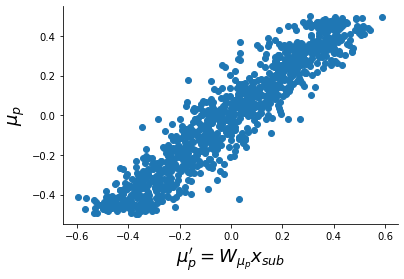

In [11]:
plt.scatter(
    np.dot(last_neural_states, mu_p_translator),
    np.array(mu_p_list),
)
plt.xlabel(r"$\mu_p'=W_{\mu_p}x_{sub}$", fontsize=18)
plt.ylabel(r'$\mu_p$', fontsize=18)
# plt.title('Sub network', fontsize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

In [12]:
sigma_p_translator = np.dot(
    np.linalg.pinv(last_neural_states),
    np.array(sigma_p_list)**2,
)

In [13]:
np.dot(last_neural_states, sigma_p_translator)[:10]

array([ 7.92998881e-02,  4.12412965e-01, -2.13258472e-04,  4.12308004e-01,
        4.85009589e-01,  3.67240562e-01,  4.24516970e-01,  4.74015748e-01,
        2.28870662e-01,  1.22844577e-01])

In [14]:
np.array(sigma_p_list[:10])**2

array([0.01124554, 0.5356278 , 0.07290745, 0.41382311, 0.49965688,
       0.28557506, 0.39087054, 0.53157847, 0.11880562, 0.16072793])

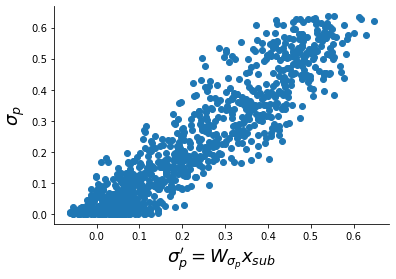

In [15]:
plt.scatter(
    np.dot(last_neural_states, sigma_p_translator),
    np.array(sigma_p_list)**2,
)
plt.xlabel(r"$\sigma_p'=W_{\sigma_p}x_{sub}$", fontsize=18)
plt.ylabel(r'$\sigma_p$', fontsize=18)
# plt.title('Sub network', fontsize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

## $\mu_p$をlikelihoodの関数として表す

In [16]:
class State:
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def __call__(self):
        return np.random.normal(self.mu, self.sigma)


def make_signal(N, time_length, uncertainty=0.5, transition_prob=0.03):
    input_signals = np.zeros([N, time_length, 100])
    phi = np.linspace(-2, 2, 100)
    sigma_sq = 0.5
    g = 1.25
    signal_mu_list = np.zeros((N, time_length))
    true_signal_list = np.zeros((N, time_length))
    
    for i in range(N):
        current_state = State(mu=np.random.rand()-0.5, sigma=np.random.rand()*0.8)
        signal_input = np.zeros([time_length, 100])
        for t in range(time_length):
            true_signal = current_state()
            true_signal_list[i, t] = true_signal
            
            signal_sigma = np.sqrt(1 / g) * uncertainty
            signal_mu = np.random.normal(true_signal, signal_sigma)
            signal_mu_list[i, t] = signal_mu
            
            signal_base = g * np.exp(-(signal_mu - phi) ** 2 / (2.0 * sigma_sq))
            signal_input[t] = np.random.poisson(signal_base)
            
            if np.random.rand() < transition_prob:
                current_state = State(mu=np.random.rand()-0.5, sigma=np.random.rand()*0.8)
        
        input_signals[i] = signal_input
        
    return input_signals, true_signal_list, signal_mu_list

In [17]:
sigma_l = math.sqrt(1/1.25) * 0.5

input_signal, _, signal_mu_list = make_signal(
    N=3000,
    time_length=100, 
    transition_prob=0.03,
)
inputs = torch.from_numpy(input_signal).float()                                 
inputs = inputs.to(device) 
hidden_np = np.random.normal(0, 0.5, size=(3000, cfg['MODEL']['SIZE']))
reservoir_np = np.random.normal(0, 0.5, size=(3000, cfg['MODEL']['RESERVOIR']))
         
hidden = torch.from_numpy(hidden_np).float()                               
hidden = hidden.to(device) 
reservoir = torch.from_numpy(reservoir_np).float()
reservoir = reservoir.to(device)
hidden_list, _, _, reservoir_list = model(inputs, hidden, reservoir, 100) 
        
neural_dynamics = hidden_list.cpu().detach().numpy()   
reservoir_dynamics = reservoir_list.cpu().detach().numpy()


In [18]:
signal_mu_list.shape

(3000, 100)

In [19]:
encoding_mu_p = np.dot(
    neural_dynamics[:, -1],
    mu_p_translator,
)

In [20]:
alpha_list = np.dot(
    np.linalg.pinv(signal_mu_list),
    encoding_mu_p,
)

Text(0, 0.5, "$\\mu_k'$")

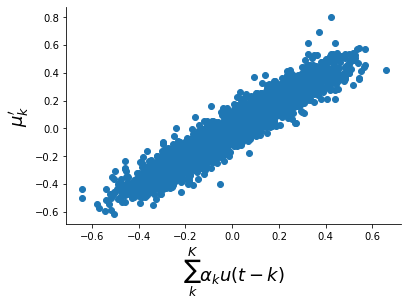

In [21]:
plt.scatter(
    np.dot(signal_mu_list, alpha_list),
    encoding_mu_p,
)
# plt.title('Sub network', fontsize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel(r'$\sum_k^K \alpha_k u(t-k)$', fontsize=18)
plt.ylabel(r"$\mu_k'$", fontsize=18)

Text(0, 0.5, '$\\alpha_k$')

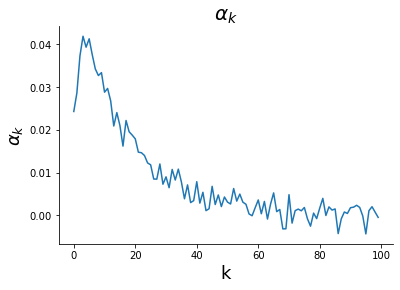

In [22]:
plt.plot(alpha_list[::-1])
plt.title(r'$\alpha_k$', fontsize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel('k', fontsize=18)
plt.ylabel(r'$\alpha_k$', fontsize=18)

In [23]:
encoding_var_p = np.dot(
    neural_dynamics[:, -1],
    sigma_p_translator,
)

In [24]:
quadratic = np.concatenate([signal_mu_list, signal_mu_list**2], axis=1)

In [25]:
quadratic.shape

(3000, 200)

In [26]:
beta_gamma_list = np.dot(
    np.linalg.pinv(quadratic),
    encoding_var_p,
)

Text(0, 0.5, "$\\sigma_k^{2'}$")

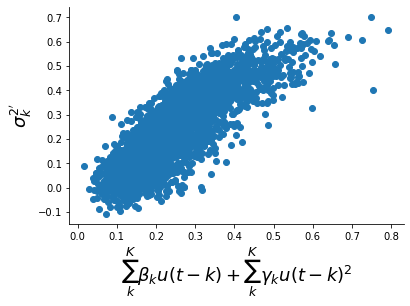

In [27]:
plt.scatter(
    np.dot(quadratic, beta_gamma_list),
    encoding_var_p,
)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel(r'$\sum_k^K \beta_k u(t-k) + \sum_k^K \gamma_k u(t-k)^2$', fontsize=18)
plt.ylabel(r"$\sigma_k^{2'}$", fontsize=18)

Text(0, 0.5, '$\\beta_k$')

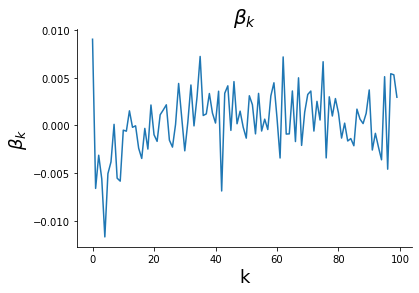

In [28]:
beta_list = beta_gamma_list[:100][::-1]
plt.plot(beta_list)

plt.title(r'$\beta_k$', fontsize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel('k', fontsize=18)
plt.ylabel(r'$\beta_k$', fontsize=18)



Text(0, 0.5, '$\\gamma_k$')

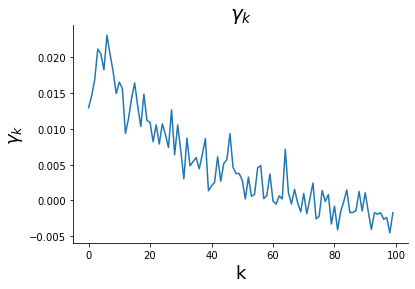

In [29]:
gamma_list = beta_gamma_list[100:][::-1]
plt.plot(gamma_list)

plt.title(r'$\gamma_k$', fontsize=20)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().yaxis.set_ticks_position('left')
plt.gca().xaxis.set_ticks_position('bottom')

plt.xlabel('k', fontsize=18)
plt.ylabel(r'$\gamma_k$', fontsize=18)